In [2]:
import pyarrow.parquet as pq
import pyarrow as pa
import pathlib, os, glob
import tempfile
import numpy as np
import pyarrow.dataset as ds
from dask import delayed
from fastparquet import ParquetFile
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from dask.distributed import Client, progress
import dask
#import graphviz
#%load_ext line_profiler
client = Client(n_workers=8, threads_per_worker=4, memory_limit='1GB')
dask.config.set({"optimization.fuse.active": False})
client

/Users/chadi/opt/miniconda3/envs/covidSP/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58800 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:58801 Dashboard: http://127.0.0.1:58800/status,Cluster Workers: 8 Cores: 32 Memory: 8.00 GB


In [3]:
geodata = pd.read_csv('../COVID19_USA/data/geodata_territories_2019_statelevel_CA-FL-MA-MD-WA.csv',
                     converters={'geoid': lambda x: str(x)})

In [22]:
all_runs = {
           # 'bad':'state-runs/bad/USA/inference/med/2021.01.12.16:31:54./global/intermediate/',
           # 'good':'state-runs/good/USA/inference/med/2021.01.08.06:30:35./global/intermediate/',
            'cdev':'s3pull/smh8-compdev/llik/USA/inference/med/R8_noWan_CA-FL-MA-MD-WA/global/intermediate/'
           }

In [23]:
max_f = -1
for name, path in all_runs.items():
    file_list = glob.glob(path + "*.parquet")
    file_list.sort()
    file_list = file_list[:max_f]
    print(name, len(file_list))
    all_runs[name] = file_list 

cdev 5099


In [24]:
resultST = {}

In [26]:
run_name = 'cdev'
filename = file_list[0]
df_csv = pq.read_table(filename).to_pandas()               
#df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
#df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
#df_csv['USPS'] = run_name
df_csv

,ll,filename,geoid
0,-9.336907e+06,model_output/llik/USA/inference/med/R8_noWan_C...,06000
1,-2.484858e+06,model_output/llik/USA/inference/med/R8_noWan_C...,12000
2,-3.693060e+05,model_output/llik/USA/inference/med/R8_noWan_C...,24000
3,-5.348576e+05,model_output/llik/USA/inference/med/R8_noWan_C...,25000
4,-1.923409e+06,model_output/llik/USA/inference/med/R8_noWan_C...,53000


In [19]:
states = ["CA"]
def read_and_label_llik_st(filename, st):
    # reads each csv file to a pandas.DataFrame
    df_csv = pq.read_table(filename).to_pandas()               
    df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
    df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
    df_csv['ID'] = st
    df_csv.groupby(['slot','sim']).sum().reset_index()
    df_csv = df_csv[['ll','sim', 'slot', 'ID']]
    return df_csv

max_f = -1

resultST = {}

for name, file_list in all_runs.items():
    # create a list of functions ready to return a pandas.DataFrame
    dfs = [delayed(read_and_label_llik_st)(fname, name) for fname in file_list]
    # using delayed, assemble the pandas.DataFrames into a dask.DataFrame
    ddfST = dd.from_delayed(dfs)
    postST = ddfST.groupby(['sim','slot','ID']).sum().compute(scheduler="threads")
    postST =  postST.reorder_levels(['ID','slot','sim']).sort_index().reset_index()
    resultST[name] = postST

KeyError: "['ll'] not in index"

In [8]:
resultST['bad']

,ID,slot,sim,ll
0,bad,1,1,-1.072938e+08
1,bad,1,2,-9.231282e+07
2,bad,1,3,-9.231282e+07
3,bad,1,4,-9.130492e+07
4,bad,1,5,-9.130492e+07
...,...,...,...,...
2493,bad,499,5,-6.142009e+07
2494,bad,500,1,-3.677745e+07
2495,bad,500,2,-3.473739e+07
2496,bad,500,3,-3.161266e+07


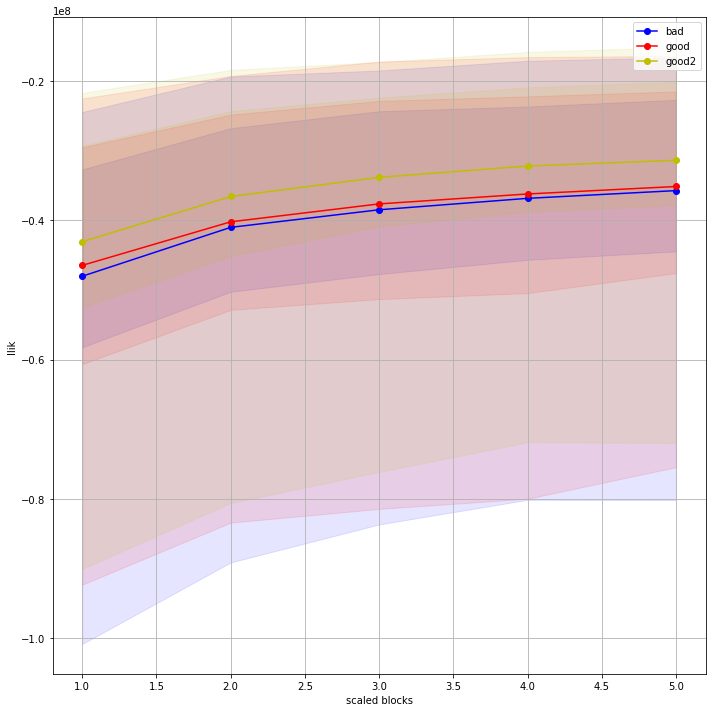

In [16]:
fig, axes = plt.subplots(1,1, figsize=(10,10), facecolor='white')
ax=axes
ax.grid()
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
ax.set_xlabel('scaled blocks')
ax.set_ylabel('llik')

colors = ['b', 'r', 'y', 'c']
i = 0

for name, result in resultST.items():
    full = result.groupby(['sim', 'slot']).sum().reset_index()
    full = full.pivot(index='sim', columns='slot', values='ll')
    #ax.plot(full, lw = .6, alpha = .5)
    ax.fill_between(full.index, full.quantile(.025, axis = 1), full.quantile(.975, axis = 1), alpha = .1, color = colors[i])
    ax.fill_between(full.index, full.quantile(.25, axis = 1), full.quantile(.75, axis = 1), alpha = .1, color = colors[i])
    ax.plot(full.index, full.mean(axis=1), marker = 'o', label = name, color = colors[i])
    i += 1
ax.legend()



fig.tight_layout()

In [107]:
df_csv = pq.read_table(filename.replace('llik','spar')).to_pandas()   

In [108]:
df_csv

,value,parameter
0,0.192308,sigma
1,0.990000,alpha
2,2.075845,r0
3,0.255233,gamma
4,0.300000,theta_1A
5,0.200000,theta_2A
6,0.650000,theta_1B
7,0.400000,theta_2B
8,0.000000,theta_WY
9,0.000000,theta_WO


In [85]:
#@dask.delayed
def read_and_label_snpi(filename):
    # reads each csv file to a pandas.DataFrame
    df_csv = pq.read_table(filename.replace('llik','snpi')).to_pandas()               
    df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
    df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
    
    df_csv['USPS'] = run_name
    df_csv = df_csv.groupby(['slot','sim', 'USPS']).mean().reset_index()
    df_csv = df_csv[['reduction','sim', 'slot', 'USPS']]
    return df_csv

# create a list of functions ready to return a pandas.DataFrame
dfs = [delayed(read_and_label_snpi)(fname) for fname in file_list]
# using delayed, assemble the pandas.DataFrames into a dask.DataFrame
ddf = dd.from_delayed(dfs)
postST = ddf.groupby(['sim','slot','USPS']).sum().compute(scheduler="threads")
postST =  postST.reorder_levels(['USPS','slot','sim']).sort_index().reset_index()
resultST[run_name] = postST

In [92]:
postST

,USPS,slot,sim,reduction
0,cdev,1,1,0.041831
1,cdev,1,2,0.045378
2,cdev,1,3,0.051542
3,cdev,1,4,0.051015
4,cdev,1,5,0.048187
...,...,...,...,...
5094,cdev,300,12,0.054858
5095,cdev,300,13,0.054858
5096,cdev,300,14,0.054858
5097,cdev,300,15,0.054858


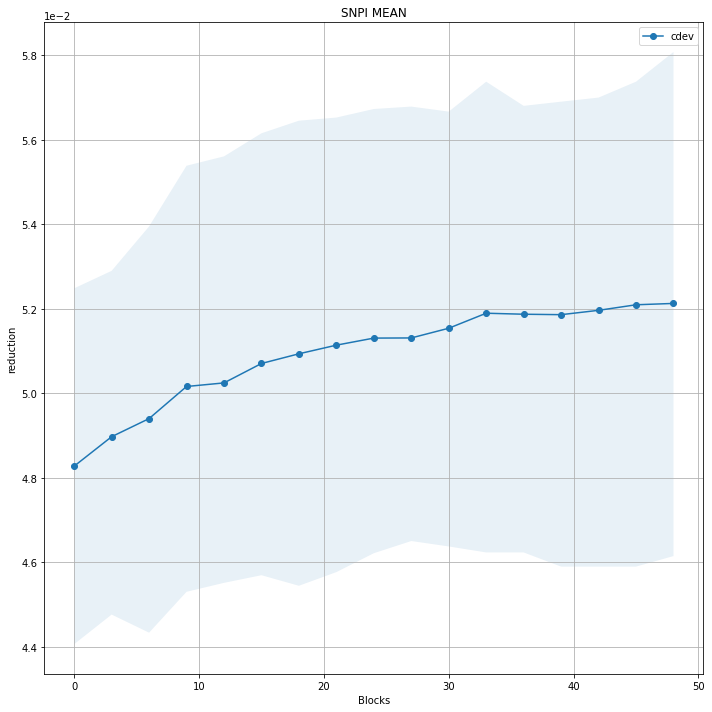

In [86]:
fig, axes = plt.subplots(1,1, figsize=(10,10), facecolor='white')

ax=axes
i = 0
ax.set_title('SNPI MEAN')
ax.grid()
#ax.set_xlim(6,22)
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#ax.set_xlim(0,25)
ax.set_xlabel('Blocks')
ax.set_ylabel('reduction')
for run_name in resultST.keys():
    full = resultST[run_name].groupby(['sim', 'slot']).mean().reset_index()
    full = full.pivot(index='sim', columns='slot', values='reduction')
    ax.fill_between((full.index-1)*3, full.quantile(.25, axis = 1), full.quantile(.75, axis = 1), alpha = .1)
    ax.plot((full.index-1)*3, full.mean(axis=1), marker = 'o', label = run_name)
    if i==0:
        ax.legend()

fig.tight_layout()

In [96]:
#@dask.delayed
def read_and_label_snpi(filename):
    # reads each csv file to a pandas.DataFrame
    df_csv = pq.read_table(filename.replace('llik','snpi')).to_pandas()               
    df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
    df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
    
    df_csv = pd.merge(df_csv, geodata, on=['geoid'], how='inner')
    df_csv = df_csv.drop('geoid', axis = 1)
    df_csv = df_csv.groupby(['USPS', 'slot','sim']).mean().reset_index()#.set_index('time', drop=True)
    df_csv = df_csv[['reduction','sim', 'slot', 'USPS']]
    return df_csv

# create a list of functions ready to return a pandas.DataFrame
dfs = [delayed(read_and_label_snpi)(fname) for fname in file_list]
# using delayed, assemble the pandas.DataFrames into a dask.DataFrame
ddf = dd.from_delayed(dfs)
postST = ddf.groupby(['sim','slot','USPS']).sum().compute(scheduler="threads")
postST =  postST.reorder_levels(['USPS','slot','sim']).sort_index().reset_index()
resultST[run_name] = postST

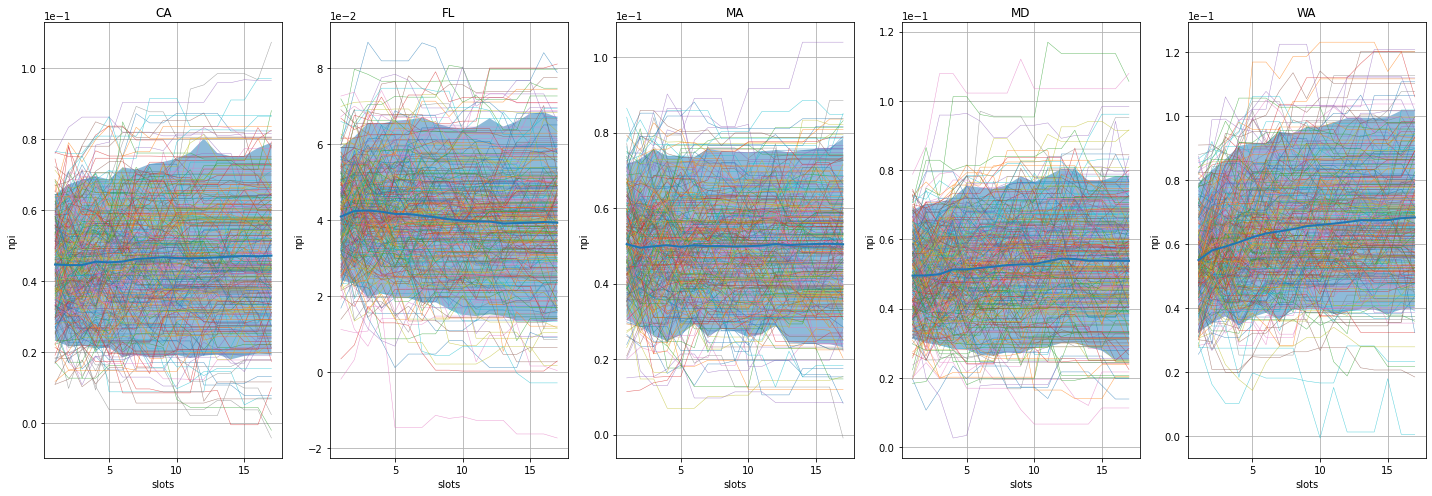

In [105]:
fig, axes = plt.subplots(1,5, figsize=(20,7), facecolor='white')#, sharey=True)

for i, ax in enumerate(axes.flat):
    sn = postST['USPS'].unique()[i]
    st = postST[postL['USPS'] == sn].pivot(index='sim', columns='slot', values='reduction')
    ax.plot(st, lw = .5, alpha = .7)
    #ax.plot(st, lw = .5)
    ax.fill_between(st.index, st.quantile(.05, axis = 1), st.quantile(.95, axis = 1), alpha = .5)
    ax.plot(st.mean(axis =1 ), lw = 2)#, marker = '.')
    #, marker = '.')
    ax.set_title(sn)
    ax.grid()
    ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
    #ax.set_ylim(-400000,0)
    #ax.set_xlim(10,25)
    ax.set_xlabel('slots')
    ax.set_ylabel('npi')
fig.tight_layout()

In [118]:
#@dask.delayed
def read_and_label_spar(filename):
    # reads each csv file to a pandas.DataFrame
    df_csv = pq.read_table(filename.replace('llik','spar')).to_pandas()               
    df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
    df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
    
    #df_csv = pd.merge(df_csv, geodata, on=['geoid'], how='inner')
    #df_csv = df_csv.drop('geoid', axis = 1)
    #df_csv = df_csv.groupby(['USPS', 'slot','sim']).mean().reset_index()#.set_index('time', drop=True)
    df_csv = df_csv[['value','sim', 'slot', 'parameter']]
    return df_csv

# create a list of functions ready to return a pandas.DataFrame
dfs = [delayed(read_and_label_spar)(fname) for fname in file_list]
# using delayed, assemble the pandas.DataFrames into a dask.DataFrame
ddf = dd.from_delayed(dfs)
postST = ddf.groupby(['sim','slot','parameter']).sum().compute(scheduler="threads")
postST =  postST.reorder_levels(['parameter','slot','sim']).sort_index().reset_index()
resultST[run_name] = postST

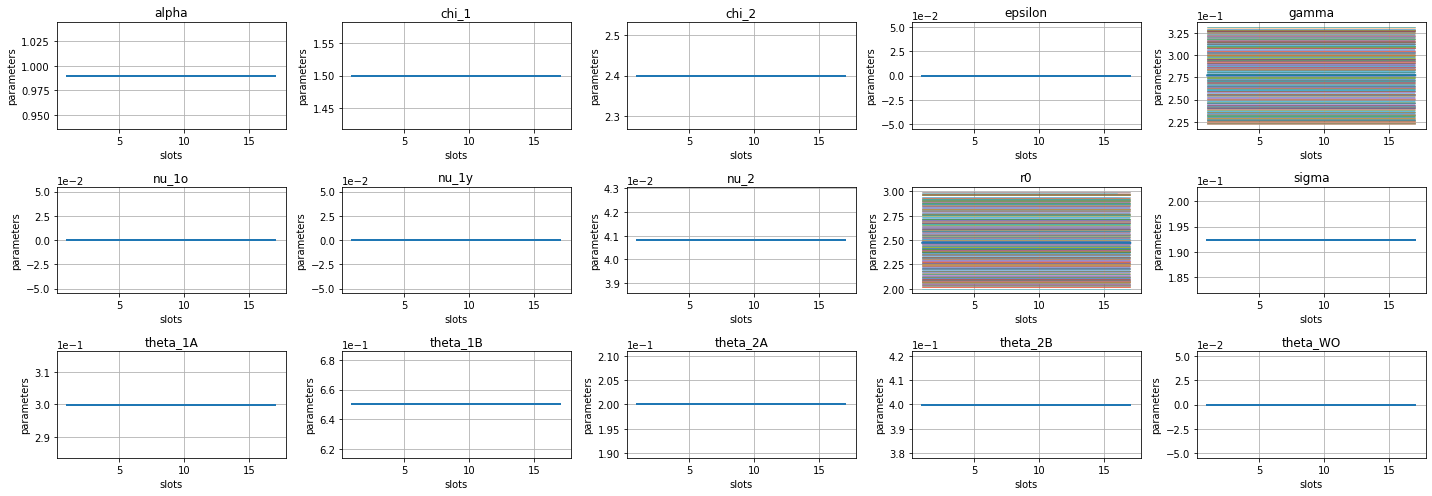

In [119]:
fig, axes = plt.subplots(3,5, figsize=(20,7), facecolor='white')#, sharey=True)

for i, ax in enumerate(axes.flat):
    sn = postST['parameter'].unique()[i]
    st = postST[postST['parameter'] == sn].pivot(index='sim', columns='slot', values='value')
    ax.plot(st, lw = .5, alpha = .7)
    #ax.plot(st, lw = .5)
    ax.fill_between(st.index, st.quantile(.05, axis = 1), st.quantile(.95, axis = 1), alpha = .5)
    ax.plot(st.mean(axis =1 ), lw = 2)#, marker = '.')
    #, marker = '.')
    ax.set_title(sn)
    ax.grid()
    ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
    #ax.set_ylim(-400000,0)
    #ax.set_xlim(10,25)
    ax.set_xlabel('slots')
    ax.set_ylabel('parameters')
fig.tight_layout()

In [139]:

df_csv = df_csv[df_csv['quantity'] == 'probability']
len(df_csv['outcome'].unique())

72

In [136]:
geodata['USPS']

0    MD
1    MA
2    WA
3    FL
4    CA
Name: USPS, dtype: object

In [134]:
#@dask.delayed
def read_and_label_hpar(filename):
    # reads each csv file to a pandas.DataFrame
    df_csv = pq.read_table(filename.replace('llik','hpar')).to_pandas()               
    df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
    df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
    df_csv = df_csv[df_csv['quantity'] == 'probability']
    df_csv['USPS'] = df_csv['geoid'].map(geodata.set_index('geoid')['USPS']) # https://stackoverflow.com/questions/36413993/replace-column-values-in-one-dataframe-by-values-of-another-dataframe
    #df_csv = pd.merge(df_csv, geodata, on=['geoid'], how='inner')
    #df_csv = df_csv.drop('geoid', axis = 1)
    #df_csv = df_csv.groupby(['USPS', 'slot','sim']).mean().reset_index()#.set_index('time', drop=True)
    df_csv = df_csv[['value','sim', 'slot', 'outcome', 'USPS']]
    return df_csv

# create a list of functions ready to return a pandas.DataFrame
dfs = [delayed(read_and_label_hpar)(fname) for fname in file_list]
# using delayed, assemble the pandas.DataFrames into a dask.DataFrame
ddf = dd.from_delayed(dfs)
postST = ddf.groupby(['sim','slot','outcome', 'USPS']).sum().compute(scheduler="threads")
postST =  postST.reorder_levels(['outcome','USPS','slot','sim']).sort_index().reset_index()
resultST[run_name] = postST

/Users/chadi/opt/miniconda3/envs/covidSP/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


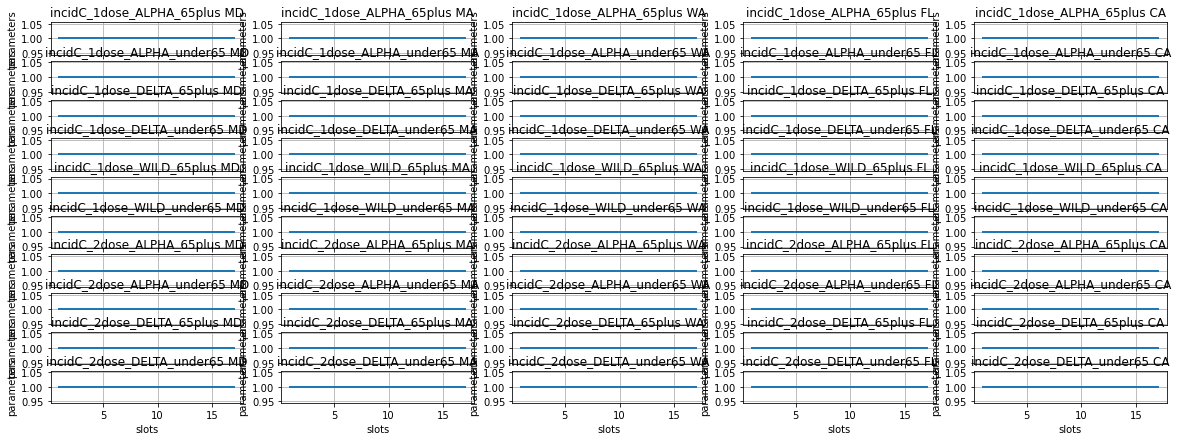

In [150]:
fig, axes = plt.subplots(10,5, figsize=(20,7), facecolor='white')#, sharey=True)

for i, ax1 in enumerate(axes):
    sn = postST['outcome'].unique()[i]
    st_al = postST[postST['outcome'] == sn]
    for i, usps in enumerate(geodata['USPS']):
        ax = ax1[i]
        st = st_al[st_al['USPS'] == usps].pivot(index='sim', columns='slot', values='value')
        ax.plot(st, lw = .5, alpha = .7)
        #ax.plot(st, lw = .5)
        ax.fill_between(st.index, st.quantile(.05, axis = 1), st.quantile(.95, axis = 1), alpha = .5)
        ax.plot(st.mean(axis =1 ), lw = 2)#, marker = '.')
        #, marker = '.')
        ax.set_title(sn + ' '+usps)
        ax.grid()
        ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
        #ax.set_ylim(-400000,0)
        #ax.set_xlim(10,25)
        ax.set_xlabel('slots')
        ax.set_ylabel('parameters')
fig.tight_layout()

In [7]:
#@dask.delayed
def read_and_label_hosp(filename):
    # reads each csv file to a pandas.DataFrame
    df_csv = pq.read_table(filename).to_pandas()               
    df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
    df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
    df_csv['state'] = state_append
    df_csv = df_csv.drop('geoid', axis = 1)
    df_csv = df_csv.groupby(['state', 'time', 'slot','sim']).sum().reset_index()#.set_index('time', drop=True)
    df_csv = df_csv[['incidC','sim', 'slot', 'state', 'time']]
    df_csv = pd.merge(df_csv, truth, on=['time', 'state'], how='inner')
    return df_csv

# create a list of functions ready to return a pandas.DataFrame
dfs = [delayed(read_and_label_hosp)(fname) for fname in file_list]
# using delayed, assemble the pandas.DataFrames into a dask.DataFrame
ddf = dd.from_delayed(dfs)

In [ ]:
ddf['errorC_abs'] = np.abs((ddf['incidC'] - ddf['incidC_T']))
ddf['errorC_rel'] = np.abs((ddf['incidC'] - ddf['incidC_T'])/ddf['incidC_T'])
ddf = ddf.replace([np.inf, -np.inf], np.nan)

In [8]:
post = ddf.groupby(['sim','slot','state']).mean().compute(scheduler="threads")  #much faster than scheduler="processes" and other alternatives #ddf = client.persist(ddf), client.compute, 

In [9]:
#ddf.visualize(rankdir='LR')

In [10]:
post =  post.reorder_levels(['state','slot','sim']).sort_index().reset_index()

In [11]:
fig, axes = plt.subplots(5,11, figsize=(30,10))

for i, ax in enumerate(axes.flat):
    sn = post['state'].unique()[i]
    st = post[post['state'] == sn].pivot(index='sim', columns='slot', values='errorC_abs')
    #ax.plot(st, lw = .5)
    #ax.plot(st.quantile(.5, axis = 1), lw = 1)
    ax.plot(st.mean(axis = 1), lw = 1)#, marker = '.')
    ax.set_title(sn)
    #ax.set_ylim(0,1000)

In [ ]:
full = post.groupby(['sim', 'slot']).sum().reset_index()

full.pivot(index='sim', columns='slot', values='errorC_rel').plot(legend=False)
full.pivot(index='sim', columns='slot', values='errorC_abs').plot(legend=False)
#post.to_csv('USA-20201109T013836-hosp.csv')

In [15]:
max_f = 5

file_list = glob.glob(path + "/*.parquet")
file_list.sort()
file_list = file_list[:max_f]

def read_and_label_CA(filename):
    # reads each csv file to a pandas.DataFrame
    df_csv = pq.read_table(filename).to_pandas()               
    df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
    df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
    df_csv['state'] = 'CA'
    df_csv = df_csv.drop('geoid', axis = 1)
    df_csv = df_csv.groupby(['state', 'time', 'slot','sim']).sum().reset_index()#.set_index('time', drop=True)
    df_csv = df_csv[['incidC','sim', 'slot', 'state', 'time']]
    df_csv = pd.merge(df_csv, truth[truth['state']=='CA'], on=['time', 'state'], how='inner')
    return df_csv

# create a list of functions ready to return a pandas.DataFrame
dfsS = [delayed(read_and_label_CA)(fname) for fname in file_list]
# using delayed, assemble the pandas.DataFrames into a dask.DataFrame
ddfS = dd.from_delayed(dfsS)

In [16]:
ddfS['errorC_abs'] = np.abs((ddfS['incidC'] - ddfS['incidC_T']))
ddfS['errorC_rel'] = np.abs((ddfS['incidC'] - ddfS['incidC_T'])/ddfS['incidC_T'])
ddfS = ddfS.replace([np.inf, -np.inf], np.nan)

In [17]:
postS = ddfS.groupby(['sim','slot','state']).mean().compute(scheduler="threads") 

In [18]:
postS =  postS.reorder_levels(['state','slot','sim']).sort_index().reset_index()

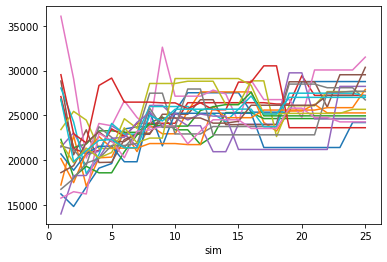

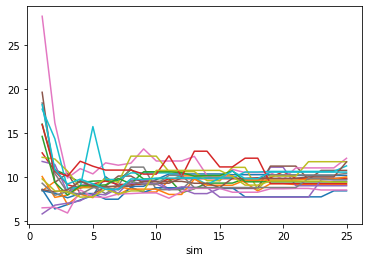

In [19]:
postS.pivot(index='sim', columns='slot', values='errorC_abs').plot(legend=False)
postS.pivot(index='sim', columns='slot', values='errorC_rel').plot(legend=False)

In [5]:
max_f = -1
path = r'state_analysis/usa' # use your path
#path = r'CA/intermediate' # use your path
file_list = glob.glob(path + "/*.parquet")
file_list.sort()
file_list = file_list[:max_f]

In [65]:
file_name=file_list[0]
df_csv = pq.read_table(filename).to_pandas()  
print(df_csv)
df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
#df_csv['state'] = state_append
print(df_csv)
df_csv = pd.merge(df_csv, geodata, on=['geoid'], how='inner')
df_csv = df_csv.drop('geoid', axis = 1)
df_csv = df_csv.groupby(['USPS', 'slot','sim']).sum().reset_index()#.set_index('time', drop=True)
df_csv = df_csv[['ll','sim', 'slot', 'USPS']]
df_csv

             ll                                           filename  geoid
0 -9.336907e+06  model_output/llik/USA/inference/med/R8_noWan_C...  06000
1 -2.484858e+06  model_output/llik/USA/inference/med/R8_noWan_C...  12000
2 -3.693060e+05  model_output/llik/USA/inference/med/R8_noWan_C...  24000
3 -5.348576e+05  model_output/llik/USA/inference/med/R8_noWan_C...  25000
4 -1.923409e+06  model_output/llik/USA/inference/med/R8_noWan_C...  53000
             ll                                           filename  geoid  \
0 -9.336907e+06  model_output/llik/USA/inference/med/R8_noWan_C...  06000   
1 -2.484858e+06  model_output/llik/USA/inference/med/R8_noWan_C...  12000   
2 -3.693060e+05  model_output/llik/USA/inference/med/R8_noWan_C...  24000   
3 -5.348576e+05  model_output/llik/USA/inference/med/R8_noWan_C...  25000   
4 -1.923409e+06  model_output/llik/USA/inference/med/R8_noWan_C...  53000   

   slot  sim  
0     1    1  
1     1    1  
2     1    1  
3     1    1  
4     1    1  


,ll,sim,slot,USPS
0,-9.336907e+06,1,1,CA
1,-2.484858e+06,1,1,FL
2,-5.348576e+05,1,1,MA
3,-3.693060e+05,1,1,MD
4,-1.923409e+06,1,1,WA


In [27]:
#@dask.delayed
def read_and_label_llik(filename):
    # reads each csv file to a pandas.DataFrame
    df_csv = pq.read_table(filename).to_pandas()               
    df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
    df_csv['sim'] = int(filename.split('/')[-1].split('.')[1])
    #df_csv['state'] = state_append
    df_csv = pd.merge(df_csv, geodata, on=['geoid'], how='inner')
    df_csv = df_csv.drop('geoid', axis = 1)
    df_csv = df_csv.groupby(['USPS', 'slot','sim']).sum().reset_index()#.set_index('time', drop=True)
    df_csv = df_csv[['ll','sim', 'slot', 'USPS']]
    return df_csv

# create a list of functions ready to return a pandas.DataFrame
dfs = [delayed(read_and_label_llik)(fname) for fname in file_list]
# using delayed, assemble the pandas.DataFrames into a dask.DataFrame
ddfL = dd.from_delayed(dfs)

In [28]:
postL = ddfL.groupby(['sim','slot','USPS']).sum().compute(scheduler="threads")

In [29]:
postL =  postL.reorder_levels(['USPS','slot','sim']).sort_index().reset_index()

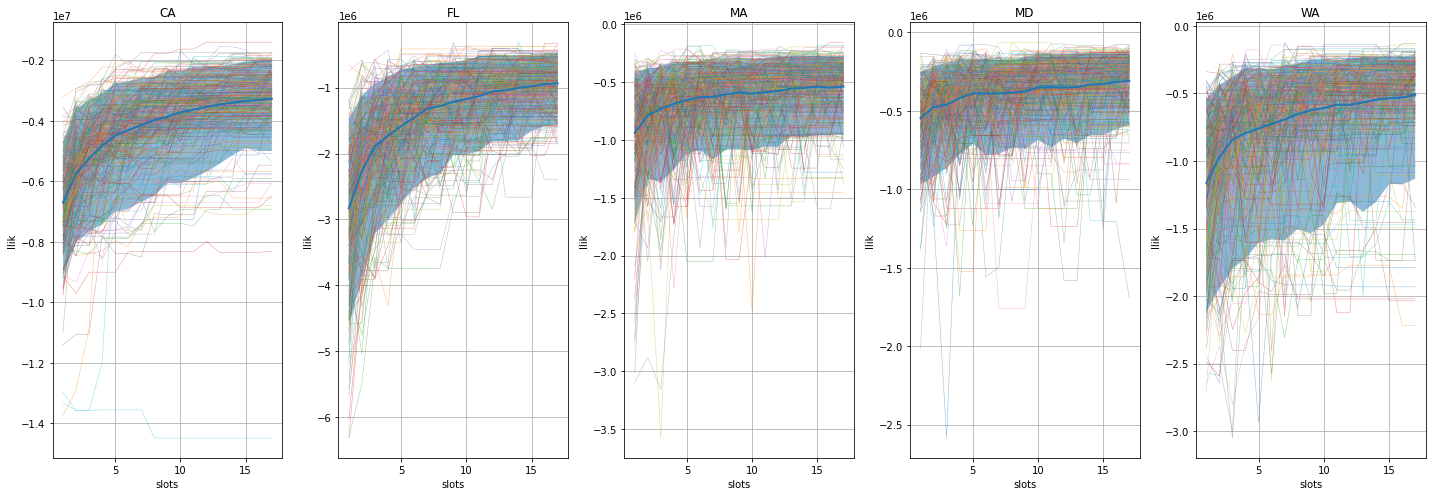

In [72]:
fig, axes = plt.subplots(1,5, figsize=(20,7), facecolor='white')#, sharey=True)

for i, ax in enumerate(axes.flat):
    sn = postL['USPS'].unique()[i]
    st = postL[postL['USPS'] == sn].pivot(index='sim', columns='slot', values='ll')
    ax.plot(st, lw = .5, alpha = .5)
    #ax.plot(st, lw = .5)
    ax.fill_between(st.index, st.quantile(.05, axis = 1), st.quantile(.95, axis = 1), alpha = .5)
    ax.plot(st.mean(axis =1 ), lw = 2)#, marker = '.')
    #, marker = '.')
    ax.set_title(sn)
    ax.grid()
    ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
    #ax.set_ylim(-400000,0)
    #ax.set_xlim(10,25)
    ax.set_xlabel('slots')
    ax.set_ylabel('llik')
fig.tight_layout()

<AxesSubplot:xlabel='sim'>

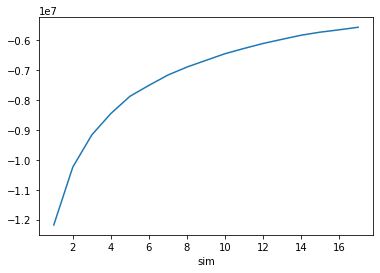

In [78]:
full = postL.groupby(['sim', 'slot']).sum().reset_index()

full.pivot(index='sim', columns='slot', values='ll').mean(axis=1).plot(legend=False)

<AxesSubplot:xlabel='sim'>

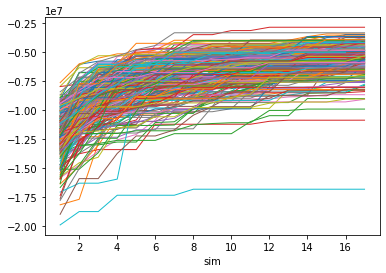

In [79]:
full.pivot(index='sim', columns='slot', values='ll').plot(legend=False, lw =1)

<AxesSubplot:xlabel='sim'>

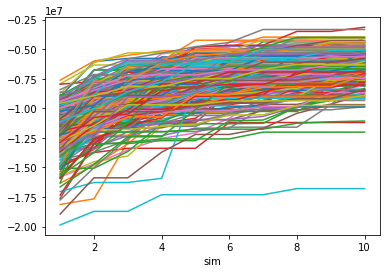

In [80]:
full.pivot(index='sim', columns='slot', values='ll')[:10].plot(legend=False)

<AxesSubplot:xlabel='sim'>

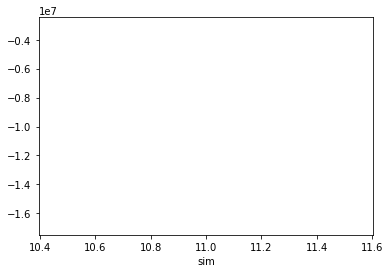

In [83]:
full.pivot(index='sim', columns='slot', values='ll')[10:-1:10].plot(legend=False)

<AxesSubplot:xlabel='sim'>

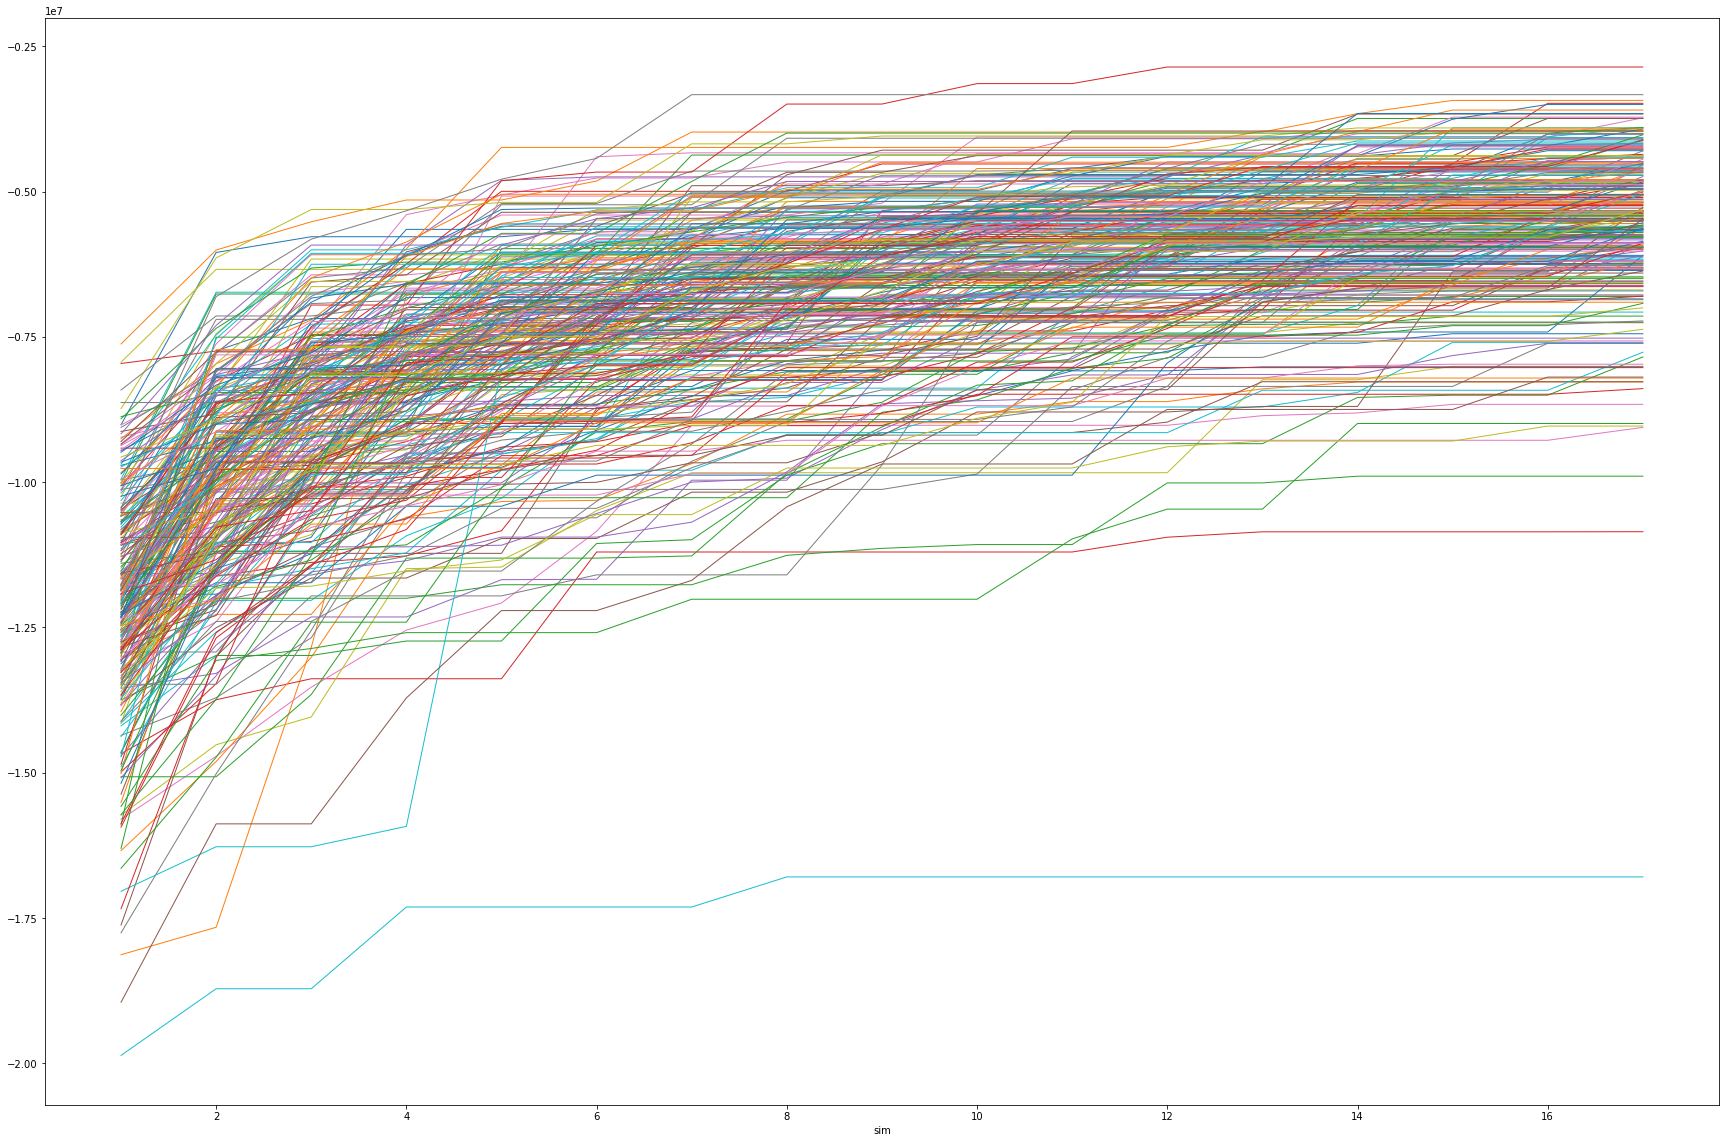

In [70]:
full.pivot(index='sim', columns='slot', values='ll').iloc[:,::1].plot(legend=False,linewidth = 1, figsize=(30,20))
#full.pivot(index='sim', columns='slot', values='ll').mean(axis=1)[10:25].plot(legend=False)

In [16]:
states = ['AK', 'AZ','SD', 'WI']

In [28]:
full

slot,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
sim,,,,,,,,,,,,,,,,,,,,,
1,-2.432678e+07,-2.439142e+07,-2.428541e+07,-2.389619e+07,-2.276652e+07,-2.443479e+07,-2.458209e+07,-2.458542e+07,-2.451539e+07,-2.429413e+07,...,-2.438279e+07,-2.442318e+07,-2.441178e+07,-2.457961e+07,-2.455497e+07,-2.454716e+07,-2.436020e+07,-2.427267e+07,-2.435954e+07,-2.478888e+07
2,-2.431102e+07,-2.398273e+07,-2.421741e+07,-2.378718e+07,-2.272116e+07,-2.416991e+07,-2.418704e+07,-2.409676e+07,-2.421724e+07,-2.394260e+07,...,-2.438279e+07,-2.408054e+07,-2.407711e+07,-2.419192e+07,-2.418947e+07,-2.428224e+07,-2.429402e+07,-2.393263e+07,-2.409933e+07,-2.430137e+07
3,-2.410547e+07,-2.394593e+07,-2.404997e+07,-2.377484e+07,-2.249722e+07,-2.405256e+07,-2.417292e+07,-2.402086e+07,-2.421724e+07,-2.394260e+07,...,-2.419385e+07,-2.403783e+07,-2.378031e+07,-2.406927e+07,-2.412076e+07,-2.428224e+07,-2.420110e+07,-2.383524e+07,-2.398836e+07,-2.424257e+07
4,-2.410547e+07,-2.377955e+07,-2.404997e+07,-2.365882e+07,-2.249722e+07,-2.391193e+07,-2.400356e+07,-2.402086e+07,-2.405502e+07,-2.389678e+07,...,-2.399237e+07,-2.378445e+07,-2.374879e+07,-2.406927e+07,-2.411505e+07,-2.424511e+07,-2.397098e+07,-2.382548e+07,-2.395751e+07,-2.416359e+07
5,-2.407277e+07,-2.377955e+07,-2.398385e+07,-2.363811e+07,-2.249722e+07,-2.391193e+07,-2.400356e+07,-2.390007e+07,-2.405502e+07,-2.371780e+07,...,-2.399237e+07,-2.378445e+07,-2.374879e+07,-2.406927e+07,-2.393276e+07,-2.414494e+07,-2.394657e+07,-2.359790e+07,-2.383572e+07,-2.412586e+07
6,-2.407277e+07,-2.371709e+07,-2.398385e+07,-2.362800e+07,-2.238042e+07,-2.391193e+07,-2.387008e+07,-2.387918e+07,-2.402575e+07,-2.371780e+07,...,-2.399237e+07,-2.378445e+07,-2.374879e+07,-2.406927e+07,-2.393276e+07,-2.410903e+07,-2.382015e+07,-2.359790e+07,-2.383572e+07,-2.407820e+07
7,-2.406571e+07,-2.365880e+07,-2.398385e+07,-2.362800e+07,-2.228423e+07,-2.391193e+07,-2.387008e+07,-2.387918e+07,-2.402575e+07,-2.371780e+07,...,-2.396175e+07,-2.378445e+07,-2.374879e+07,-2.404409e+07,-2.383382e+07,-2.403368e+07,-2.382015e+07,-2.359790e+07,-2.381978e+07,-2.404549e+07
8,-2.406571e+07,-2.359710e+07,-2.392215e+07,-2.356078e+07,-2.228423e+07,-2.388114e+07,-2.387008e+07,-2.387918e+07,-2.402575e+07,-2.366006e+07,...,-2.396175e+07,-2.370197e+07,-2.374879e+07,-2.401216e+07,-2.383382e+07,-2.403368e+07,-2.382015e+07,-2.351533e+07,-2.381978e+07,-2.401781e+07
9,-2.406260e+07,-2.354294e+07,-2.392215e+07,-2.350811e+07,-2.215403e+07,-2.378601e+07,-2.387008e+07,-2.387918e+07,-2.398166e+07,-2.355294e+07,...,-2.396175e+07,-2.370197e+07,-2.370579e+07,-2.401019e+07,-2.383382e+07,-2.403368e+07,-2.382015e+07,-2.337559e+07,-2.375681e+07,-2.401781e+07


In [1]:
comp = 'S'
def read_and_label_seir_st(filename, st):
    # reads each csv file to a pandas.DataFrame
    df_csv = pq.read_table(filename).to_pandas()               
    df_csv = df_csv[df_csv['comp']==comp].set_index('time', drop=True).drop('comp',axis = 1).sum(axis=1)
    df_csv = pd.DataFrame(df_csv)
    df_csv['slot'] = int(filename.split('/')[-1].split('.')[0])
    return df_csv

In [9]:
path = f'state_analysis/SDseirOther'
file_list = glob.glob(path + "/*.parquet")
file_list.sort()
file_list = file_list[:max_f]
sn = 'SD'
# create a list of functions ready to return a pandas.DataFrame
dfs = [delayed(read_and_label_seir_st)(fname, sn) for fname in file_list]
# using delayed, assemble the pandas.DataFrames into a dask.DataFrame
ddfSE = dd.from_delayed(dfs)

In [10]:
postSE = ddfSE.compute(scheduler="threads")

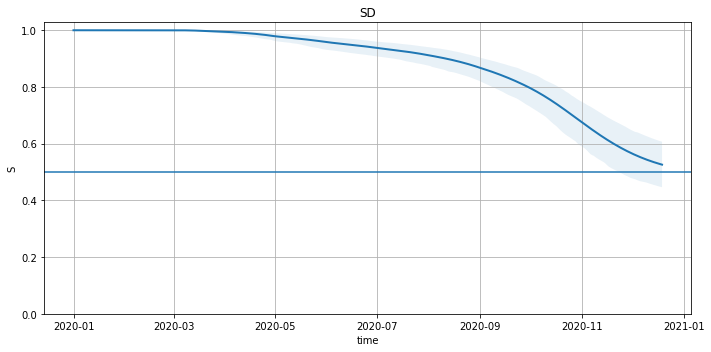

In [12]:
fig, axes = plt.subplots(1,1, figsize=(10,5), facecolor='white')

ax = axes
st = postSE.pivot(columns='slot', values=0)
st = st/max(st[1])

ax.fill_between(st.index, st.quantile(.05, axis = 1), st.quantile(.95, axis = 1), alpha = .1)
ax.plot(st.mean(axis = 1 ), lw = 2,  label = 'nation')
ax.set_title(sn)
ax.axhline(.50)

ax.grid()
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
ax.set_ylim(0)
ax.set_xlabel('time')
ax.set_ylabel(comp)
    
fig.tight_layout()